In [20]:
import math
import numpy as np
import pandas as pd
from pylab import mpl, plt
import pandas_datareader.data as web

In [2]:
S0= 100
K = 105
T = 1.0
r = 0.05
sigma = 0.2
I = 10000
np.random.seed(1000)

z = np.random.standard_normal(I)

In [3]:
ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * z)
hT = np.maximum(ST - K, 0)
C0 = math.exp(-r * T) * np.mean(hT)

In [4]:
print('Value of the European call option: {:5.3f}.'.format(C0)) 


Value of the European call option: 8.008.


In [1]:
import math
loops = 2500000
a = range(1, loops)
def f(x):
    return 3*math.log(x) + math.cos(x)**2

%timeit r = [f(x) for x in a]

1.11 s ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
import numpy as np
a = np.arange(1, loops)

%timeit r = 3* np.log(a) + np.cos(a)**2

50.5 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
import numexpr as ne
ne.set_num_threads(1)
f = '3*log(a) + cos(a)**2'
%timeit r = ne.evaluate(f)


35.3 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
ne.set_num_threads(4)
%timeit r = ne.evaluate(f)

11.2 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### From Prototying to Production

In [16]:
# import eikon as ek
# data = ek.get_timeseries('AAPL.O', fields = '*', start_date='2018-10-18 16:00:00', 
#                         end_date='2018-10-18 17:00:00',
#                         interval='tick')

# data = ek.get_timeseries('AAPL.O', fields='*',
#  start_date='2018-10-18 16:00:00',
# end_date='2018-10-18 17:00:00',
# interval='tick') 

In [17]:
# pip install eikon

In [33]:
data = web.DataReader('WIPRO.NS', 'yahoo', '2016-01-01','2022-09-30')
data['return'] = np.log(data['Close'] / data['Close'].shift())
lags = 7

cols = []
for lag in range(1, lags+1):
    col = f'lag_{lag}'
    data[col] = np.sign(data['Close'].shift(lag))
    cols.append(col)
data.dropna(inplace=True)

In [34]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,return,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,,,,,,
2016-01-12,206.625046,199.200043,201.187546,205.837555,3491084.0,198.245804,0.021081,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-13,206.962555,202.668793,205.125046,204.937546,1793783.0,197.378983,-0.004382,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-14,206.212555,201.000046,204.375046,204.468796,2919332.0,196.927505,-0.002290,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-15,205.818802,201.375046,204.975052,203.662552,1667087.0,196.151016,-0.003951,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-18,206.550049,199.031296,201.375046,205.181305,4515961.0,197.613770,0.007430,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [35]:
from sklearn.svm import SVC
model = SVC(gamma='auto')

model.fit(data[cols], np.sign(data['return']))
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, 
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf', 
   max_iter=-1, probability=False, random_state=None,shrinking=True, tol=0.001, verbose=False)

SVC(gamma='auto')

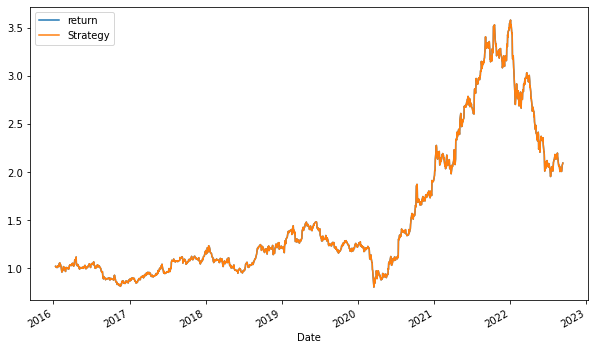

In [36]:
data['Prediction'] = model.predict(data[cols])
data['Strategy'] = data['Prediction']*data['return']
data[['return', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10,6));